In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [2]:
# The function used to generate data, the Runge function
def Runge_func(x):
    return 1.0/(1 + 25*x**2)

In [3]:
# Functions used

def polynomial_features(x, p, intercept=False):
    """
    Take an array of x values, and the desired polynomial degree p.
    Create a feature (design) matrix with first column x**1, second column with x**2, and so on. I.e. the i-th column containing x**(i+1).
    Intercept=True will turn the first column into ones, meaning the i-th column will contain the value x**(j).
    """
    n = len(x)
    x = x.ravel()
    if intercept  == True:
        X = np.zeros((int(n), int(p + 1)))
        for i in range(0, int(p+1)):
            X[:, i] = x**i  # Create first column with only ones (since x**0 = 1), the intercept column
    else:
        X = np.zeros((int(n), int(p)))
        for i in range(0, int(p)):
            X[:, i] = x**(i+1)
    return X

def OLS_parameters(X, y):
    """
    The closed form solution of least square optimization.
    Take a feature matrix X, and a column vector y.
    Return the parameters of OLS fit.
    """
    # The inverse of matrix X, using .pinv in case X is not square
    # The beta vector in: X @ beta = y, solved for beta
    beta = np.linalg.pinv(X.T @ X) @ X.T @ y   
    return beta

def Ridge_parameters(X, y, ridge_lambda):
    """
    The closed form solution of Ridge optimization.
    Take a feature matrix X, and a column vector y, and the Ridge lambda parameter.
    Return the beata parameters of the Ridge fit.
    """
    # Assumes X is scaled and has no intercept column
    I = np.identity(np.shape(X)[1])    # Create identity matrix same shape as X.T @ X, columns of X decide the shape, (nxm)(mxn)=(nxn)
    # Element-wise multiplication with *
    beta = np.linalg.pinv(X.T @ X + ridge_lambda*I) @ X.T @ y
    return beta

def grad_C_OLS(XTX, XTy, y, theta, n):
    """ 
    Calculate the gradient of the cost function C for OLS. Original expression: (2.0/n)*(X.T @ X @ theta - X.T @ y).
    Take the matrix multiplication involving features X.T@X, and X.T@y; target vector y; the parameter vector theta; and n data points.
    Usually used in a grad decent/accent loop, therefore having the factors X.T@X and X.T@y precalculated for speed improvement. 
    Return the calculated gradient. 
    """
    y = y.reshape(-1,1)
    theta = theta.reshape(-1,1)
    return (2.0/n)*(XTX @ theta - XTy)

def grad_C_Ridge(XTX, XTy, y, theta, n, ridge_lambda):
    """ 
    Calculate the gradient of the cost function C for Ridge. Original expression: (2.0/n)*(X.T @ X @ theta - X.T @ y) + 2*ridge_lambda*theta.
    Take the matrix multiplication involving features X.T@X, and X.T@y; target vector y; the parameter vector theta; n data point; and ridge_lambda. 
    Usually used in a grad decent/accent loop, therefore having X.T@X and X.T@y precalculated for speed improvement. 
    Return the calculated gradient. 
    """
    y = y.reshape(-1,1)
    theta = theta.reshape(-1,1)
    return (2.0/n)*(XTX @ theta - XTy) + 2*ridge_lambda*theta

In [4]:
# MSE for Ridge regression for different polynomials and lambda_ridges values.
np.random.seed(2025)

# Number of data points
n = 1000

# Setting up data
std = 0.5
x = np.linspace(-1, 1, n)
y = Runge_func(x) + np.random.normal(0, std, size=n)

poly_min = 1
poly_max = 15
poly_degrees = np.arange(poly_min, poly_max + 1, 1)

exp_start = -8
exp_stop = 6
n_ridge_lambdas = 20
ridge_lambdas = np.logspace(exp_start, exp_stop, n_ridge_lambdas)

runs = 500

mse_matrix_run_poly_lambda = np.zeros([runs, len(poly_degrees), len(ridge_lambdas)])
r2_matrix_run_poly_lambda = np.zeros([runs, len(poly_degrees), len(ridge_lambdas)])

for i in range(runs):
    np.random.seed(2025 + i)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    for j in range(len(poly_degrees)):
        np.random.seed(1025 + j)
        X_train_poly = polynomial_features(x_train, poly_degrees[j], intercept=False)
        X_test_poly = polynomial_features(x_test, poly_degrees[j], intercept=False)

        # Scaling of the data
        scaler = StandardScaler()   # initialize scaler method
        scaler.fit(X_train_poly)    # only base the scaling on X_train, to prevent data leakage from X_test 
        X_train_s = scaler.transform(X_train_poly)
        X_test_s = scaler.transform(X_test_poly)
        y_offset = np.mean(y_train) # Nesecarry to add this to the y prediction since we have not used intercept parameter

        for k in range(len(ridge_lambdas)):
            # Train model/find beta parameters
            beta = Ridge_parameters(X_train_s, y_train, ridge_lambda=ridge_lambdas[k])
            # Doing the prediction
            predict_y_test_poly = X_test_s @ beta + y_offset # add y_offset since no intercept feature
            
            mse_matrix_run_poly_lambda[i,j,k] = mean_squared_error(y_test, predict_y_test_poly)
            r2_matrix_run_poly_lambda[i,j,k] = 1.0 - (np.sum((y_test - predict_y_test_poly)**2)/(np.sum((y_test - np.mean(y_test))**2)))

mean_mse_polys_lambdas = np.mean(mse_matrix_run_poly_lambda, axis=0)
mean_r2_polys_lambdas = np.mean(r2_matrix_run_poly_lambda, axis=0)

In [ ]:
data_to_save_ridge_lambdas = np.c_[ridge_lambdas]
data_to_save_poly_degrees = np.c_[poly_degrees]
data_to_save_MSE = np.c_[mean_mse_polys_lambdas]
data_to_save_R2 = np.c_[mean_r2_polys_lambdas]

np.savetxt("data_rlambda_MSE_polydegrees_Ridge_RIDGE_LAMBDAS.out", data_to_save_ridge_lambdas)
np.savetxt("data_rlambda_MSE_polydegrees_Ridge_POLY_DEGREES.out",data_to_save_poly_degrees)
np.savetxt("data_rlambda_MSE_polydegrees_Ridge_MSEs.out", data_to_save_MSE, header="poly_degree x ridge lambda")
np.savetxt("data_rlambda_MSE_polydegrees_Ridge_R2.out", data_to_save_R2, header="poly degree x R2")

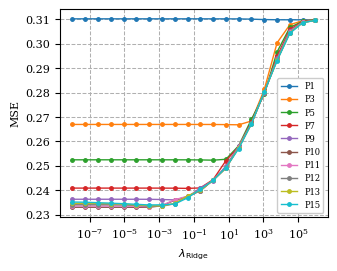

In [30]:
import matplotlib
from matplotlib.ticker import MultipleLocator

MM_TO_INCH = 1/25.4

matplotlib.rc("text", usetex=False)
plt.rc('lines', linewidth=1.0)
plt.rc("figure", autolayout=True)
plt.rc("legend", fontsize=6)
plt.rc("font", family="serif", size=8)
plt.figure(figsize=(86.78*MM_TO_INCH, 70*MM_TO_INCH))
plt.ticklabel_format(axis = "y", style="sci")
#plt.gca().xaxis.set_major_locator(MultipleLocator(base=2, offset=-1))   # Configure the markers on the x axis
plt.grid(True, which="both", linestyle="--", linewidth=0.75)


for deg in np.array([0,2,4,6,8,9,10,11,12,14]):#range(len(poly_degrees)):
    plt.semilogx(ridge_lambdas, mean_mse_polys_lambdas[deg,:], ".-", markersize="5", label=f"P{poly_degrees[deg]}")
plt.legend()
plt.xlabel(r"$\lambda_\text{Ridge}$")
plt.ylabel("MSE")
# plt.title(
#     f"MSE(test-target and prediction) for analytic Ridge regression of {n} data points, \n" 
#     f"for a selection of polynomial degrees, with {n_ridge_lambdas} different values of $\\lambda_{{\\text{{Ridge}}}}$, \n"
#     f"averaged over {runs} runs, data std.: {std}"
# )
plt.legend().get_frame().set_alpha(1.0) # Add solid background (non see thru) to legend box
plt.savefig("rlambdas_MSE_polys_Ridge.pdf", bbox_inches="tight")
plt.show()
plt.close()

IndexError: index 6 is out of bounds for axis 0 with size 6

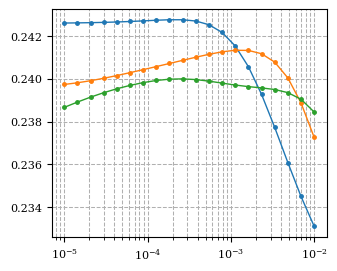

In [55]:
MM_TO_INCH = 1/25.4

matplotlib.rc("text", usetex=False)
plt.rc('lines', linewidth=1.0)
plt.rc("figure", autolayout=True)
plt.rc("legend", fontsize=6)
plt.rc("font", family="serif", size=8)
plt.figure(figsize=(86.78*MM_TO_INCH, 70*MM_TO_INCH))
plt.ticklabel_format(axis = "y", style="sci")
#plt.gca().xaxis.set_major_locator(MultipleLocator(base=2, offset=-1))   # Configure the markers on the x axis
plt.grid(True, which="both", linestyle="--", linewidth=0.75)



for deg in np.array([0,2,4,6,8,9,10,11,12,14]):#range(len(poly_degrees)):
    plt.semilogx(ridge_lambdas, mean_r2_polys_lambdas[deg,:], ".-", markersize="5", label=f"P{poly_degrees[deg]}")
plt.legend()
plt.xlabel(r"$\lambda_\text{Ridge}$")
plt.ylabel("$R^2$")
# plt.title(
#     f"R^2(test-target and prediction) for analytic Ridge regression of {n} data points, \n" 
#     f"a selection of polynomial degrees, and {n_ridge_lambdas} calculated values of $\\lambda_{{\\text{{Ridge}}}}$, \n"
#     f"averaged over {runs} runs"
# )
plt.grid(True, which="both", linestyle="--", linewidth=0.75)
plt.legend().get_frame().set_alpha(1.0) # Add solid background (non see thru) to legend box
plt.savefig("rlambdas_R2_polys_Ridge.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
# Circling in on optimal ridge_lambda based on plot above
np.random.seed(2025)

# Number of data points
n = 1000

# Setting up data
x = np.linspace(-1, 1, n)
y = Runge_func(x) + np.random.normal(0, 0.5, size=n)

poly_min = 10
poly_max = 15
poly_degrees = np.arange(poly_min, poly_max + 1, 1)

exp_start = -5
exp_stop = -2
n_ridge_lambdas = 20
ridge_lambdas = np.logspace(exp_start, exp_stop, n_ridge_lambdas)

runs = 500

mse_matrix_run_poly_lambda = np.zeros([runs, len(poly_degrees), len(ridge_lambdas)])
r2_matrix_run_poly_lambda = np.zeros([runs, len(poly_degrees), len(ridge_lambdas)])

for i in range(runs):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    for j in range(len(poly_degrees)):
        X_train_poly = polynomial_features(x_train, poly_degrees[j], intercept=False)
        X_test_poly = polynomial_features(x_test, poly_degrees[j], intercept=False)

        # Scaling of the data
        scaler = StandardScaler()   # initialize scaler method
        scaler.fit(X_train_poly)    # only base the scaling on X_train, to prevent data leakage from X_test 
        X_train_s = scaler.transform(X_train_poly)
        X_test_s = scaler.transform(X_test_poly)
        y_offset = np.mean(y_train) # Nesecarry to add this to the y prediction since we have not used intercept parameter

        for k in range(len(ridge_lambdas)):
            # Train model/find beta parameters
            beta = Ridge_parameters(X_train_s, y_train, ridge_lambda=ridge_lambdas[k])
            # Doing the prediction
            predict_y_test_poly = X_test_s @ beta + y_offset # add y_offset since no intercept feature
            
            mse_matrix_run_poly_lambda[i,j,k] = mean_squared_error(y_test, predict_y_test_poly)
            r2_matrix_run_poly_lambda[i,j,k] = 1.0 - (np.sum((y_test - predict_y_test_poly)**2)/(np.sum((y_test - np.mean(y_test))**2)))

mean_mse_polys_lambdas = np.mean(mse_matrix_run_poly_lambda, axis=0)
mean_r2_polys_lambdas = np.mean(r2_matrix_run_poly_lambda, axis=0)


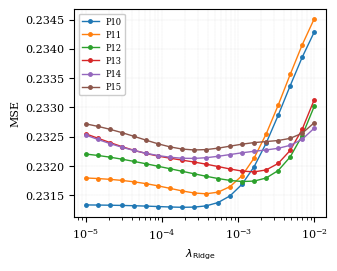

In [59]:
MM_TO_INCH = 1/25.4

matplotlib.rc("text", usetex=False)
plt.rc('lines', linewidth=1.0)
plt.rc("figure", autolayout=True)
plt.rc("legend", fontsize=6)
plt.rc("font", family="serif", size=8)
plt.figure(figsize=(86.78*MM_TO_INCH, 70*MM_TO_INCH))
plt.ticklabel_format(axis = "y", style="sci")
#plt.gca().xaxis.set_major_locator(MultipleLocator(base=2, offset=-1))   # Configure the markers on the x axis

for deg in range(len(poly_degrees)):
    plt.semilogx(ridge_lambdas, mean_mse_polys_lambdas[deg,:], ".-", markersize="5", label=f"P{poly_degrees[deg]}")
plt.legend()
plt.xlabel(r"$\lambda_\text{Ridge}$")
plt.ylabel("MSE")
# plt.title(
#     f"MSE(test-target and prediction) \n"
#     f"for Ridge regression of {n} data points, \n" 
#     f"for a selection of polynomial degrees, \n"
#     f"with {n_ridge_lambdas} different values of $\\lambda_{{\\text{{Ridge}}}}$, \n"
#     f"averaged over {runs} runs"
# )
plt.grid(True, which="both", linestyle="--", linewidth=0.1)
plt.legend().get_frame().set_alpha(1.0) # Add solid background (non see thru) to legend box
plt.savefig("rlambda_MSE_selected_polys_closeup.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [48]:
index_min = np.argmin(mean_mse_polys_lambdas[-1,:])
ridge_lambda_minimize_P10 = ridge_lambdas[index_min]
print(ridge_lambda_minimize_P10)
# Manually round off to three significant digits
ridge_lambda_minimize_P10 = 0.000886 # for standard deviation 1.0
ridge_lambda_minimize_P10 = 0.000264 # for standard deviation 0.5

0.00026366508987303583


MSE prediction analytic: 0.22014789702730725
MSE prediction gradient decent: 0.22484460258103006


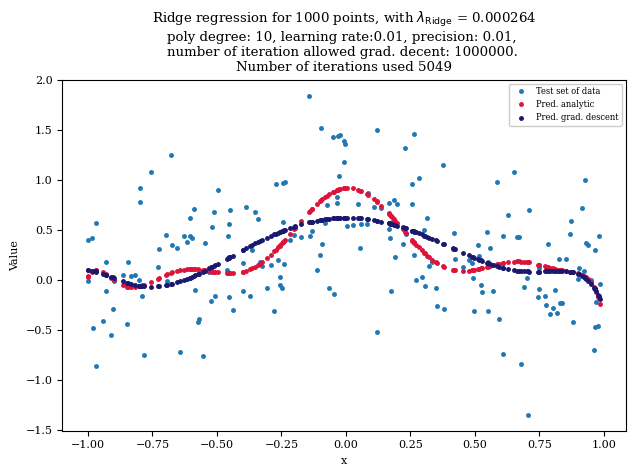

In [ ]:
def grad_C_Ridge(XTX, XTy, theta, n, ridge_lambda):
    """ 
    Calculate the gradient of the cost function C for Ridge. Original expression: (2.0/n)*(X.T @ X @ theta - X.T @ y) + 2*ridge_lambda*theta.
    Take the matrix multiplication involving features X.T@X, and X.T@y; target vector y; the parameter vector theta; n data point; and ridge_lambda. 
    Usually used in a grad decent/accent loop, therefore having X.T@X and X.T@y precalculated for speed improvement. 
    Return the calculated gradient. 
    """
    theta = theta.reshape(-1,1)
    return (2.0/n)*(XTX @ theta - XTy) + 2*ridge_lambda*theta

def simple_gradient_decent_Ridge(X, y, theta, n, ridge_lambda=0.01, eta=0.01, precision=1e-8, num_iter=10000):
    """
    Find the theta that minimize the Ridge cost function iteratively. Run till precision requirement epsilon is met.
    Take feature matrix X, target vector y, parameter vector theta, n data points, ridge_lambda, learning rate eta, 
    precision of grad==0, and number of iterations num_iter.
    Return updated parameter vector theta, and number of iterations used i.
    """
    y = y.reshape(-1,1)
    theta = theta.reshape(-1,1)
    if np.shape(X)[0] != np.shape(y)[0]:
        raise ValueError("X and y is not of right shape")
    XTX = X.T @ X
    XTy = X.T @ y
    i = 0
    grad = grad_C_Ridge(XTX, XTy, theta, n, ridge_lambda)
    while np.linalg.norm(grad) > precision:
        theta -= eta*grad
        grad = grad_C_Ridge(XTX, XTy, theta, n, ridge_lambda)
        i += 1
        if i > num_iter:
            break
    return theta, i

# Simple gradient decent Ridge compared to analytic ridge for a specific set of parameters

np.random.seed(2025)

# Number of data points
n = 1000
# Setting up data
x = np.linspace(-1, 1, n)
y = Runge_func(x) + np.random.normal(0, 0.5, size=n)

poly_deg = 10
ridge_lambda = ridge_lambda_minimize_P10

X = polynomial_features(x, poly_deg, intercept=False)

X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, np.arange(len(x)), test_size=0.2) # Tracks indices of x value in X_train and X_Test, for plotting later

# Scaling of the data
scaler = StandardScaler()   # initialize scaler method
scaler.fit(X_train)    # only base the scaling on X_train, to prevent data leakage from X_test 
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
y_offset = np.mean(y_train) # Nesecarry to add this to the y prediction since we have not used intercept parameter

# theta parameters from closed form analytic solution
theta_analytic = Ridge_parameters(X_train_s, y_train, ridge_lambda=ridge_lambda)
prediction_testdata_analytic_theta = X_test_s @ theta_analytic + y_offset

# theta parameters from gradient decent method
learning_rate = 0.01
precision = 0.01
num_iterations = 1000000
theta_start = np.ones([np.shape(X)[1]])

theta_grad_decent, iterations = simple_gradient_decent_Ridge(X_train_s, y_train, theta_start, n, ridge_lambda=ridge_lambda, eta=learning_rate, precision=precision, num_iter=num_iterations)
prediction_testdata_gradient_decent_theta = X_test_s @ theta_grad_decent + y_offset

mse_ytest_prediction_analytic = mean_squared_error(y_test, prediction_testdata_analytic_theta)
mse_ytest_prediction_grad_decent = mean_squared_error(y_test, prediction_testdata_gradient_decent_theta)
print(f"MSE prediction analytic: {mse_ytest_prediction_analytic}")
print(f"MSE prediction gradient decent: {mse_ytest_prediction_grad_decent}")


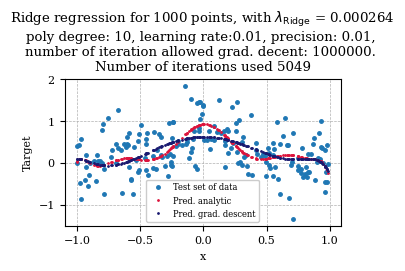

In [ ]:

import matplotlib
from matplotlib.ticker import MultipleLocator

MM_TO_INCH = 1/25.4

matplotlib.rc("text", usetex=False)
plt.rc('lines', linewidth=1.0)
plt.rc("figure", autolayout=True)
plt.rc("legend", fontsize=6)
plt.rc("font", family="serif", size=8)
plt.figure(figsize=(86.78*MM_TO_INCH, 70*MM_TO_INCH))
plt.ticklabel_format(axis = "y", style="sci")
#plt.gca().xaxis.set_major_locator(MultipleLocator(base=0.5, offset=-1))   # Configure the markers on the x axis
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.plot(x[test_idx], y[test_idx], ".", markersize="5.0", label="Test data")
plt.plot(x[test_idx], prediction_testdata_analytic_theta, ".", color="crimson", markersize="2.0", label="Pred. analytic")
plt.plot(x[test_idx], prediction_testdata_gradient_decent_theta, ".", color="midnightblue", markersize="2.0", label="Pred. grad. descent")

plt.title(f"Ridge regression for {n} points, with $\lambda_\\text{{Ridge}}$ = {ridge_lambda} \n"
          f"poly degree: {poly_deg}, learning rate:{learning_rate}, precision: {precision}, \n"
          f"number of iteration allowed grad. decent: {num_iterations}. \n"
          f"Number of iterations used {iterations}"
         )
plt.xlabel("x")
plt.ylabel("Targets")
plt.legend().get_frame().set_alpha(1.0)
plt.savefig("P10_optimal_rlambda_fit_analytic_grad_decent_.pdf", bbox_inches="tight")
plt.show()
plt.close()